In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

Using TensorFlow backend.


In [2]:
%%time
train_transaction = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")
test_transaction = pd.read_csv("../input/ieee-fraud-detection/test_transaction.csv")
train_identity = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")
test_identity = pd.read_csv("../input/ieee-fraud-detection/test_identity.csv")

CPU times: user 46.5 s, sys: 17.8 s, total: 1min 4s
Wall time: 1min


In [3]:
print ("Training Transaction Dataset Shape: {}".format(train_transaction.shape))
print ("Testing Transaction Dataset Shape: {}".format(test_transaction.shape))
print ("Training Identity Dataset Shape: {}".format(train_identity.shape))
print ("Testing Identity Dataset Shape: {}".format(test_identity.shape))

Training Transaction Dataset Shape: (590540, 394)
Testing Transaction Dataset Shape: (506691, 393)
Training Identity Dataset Shape: (144233, 41)
Testing Identity Dataset Shape: (141907, 41)


In [4]:
print ("Unique Transaction ID's in Training Set",train_transaction['TransactionID'].nunique())
print ("Unique Transaction ID's in Training Identity Set",train_identity['TransactionID'].nunique())
print ("-------------------------------------------------------------")
print ("Unique Transaction ID's in Testing Set",test_transaction['TransactionID'].nunique())
print ("Unique Transaction ID's in Testing Identity Set",test_identity['TransactionID'].nunique())

Unique Transaction ID's in Training Set 590540
Unique Transaction ID's in Training Identity Set 144233
-------------------------------------------------------------
Unique Transaction ID's in Testing Set 506691
Unique Transaction ID's in Testing Identity Set 141907


In [5]:
%%time
train = pd.merge(left=train_transaction,right=train_identity,on='TransactionID',how='left')
test = pd.merge(left=test_transaction,right=test_identity,on='TransactionID',how='left')

CPU times: user 11.3 s, sys: 16.3 s, total: 27.6 s
Wall time: 27.5 s


In [6]:
del train_transaction, test_transaction, train_identity, test_identity

In [7]:
train.drop("TransactionID",axis=1,inplace=True)
Submission = test[['TransactionID']]
test.drop("TransactionID",axis=1,inplace=True)

In [8]:
print (train.shape)
print (test.shape)

(590540, 433)
(506691, 432)


In [9]:
missing_train = []
missing_test = []
for col in train.columns:
    if train[col].isna().sum() / len(train) > 0.90:
        missing_train.append(col)
for col in test.columns:
    if test[col].isna().sum() / len(test) > 0.90:
        missing_test.append(col)
print ("Following are the columns in Training Data with more than 90% missing values:",missing_train)
print ("Following are the columns in Test Data with more than 90% missing values:",missing_test)

Following are the columns in Training Data with more than 90% missing values: ['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
Following are the columns in Test Data with more than 90% missing values: ['dist2', 'id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [10]:
common_elements = list(set(missing_train).intersection(missing_test))
common_elements

['id_22',
 'id_08',
 'id_26',
 'id_21',
 'dist2',
 'id_23',
 'id_24',
 'id_25',
 'id_07',
 'id_27']

In [11]:
train.drop(common_elements,axis=1,inplace=True)
test.drop(common_elements,axis=1,inplace=True)

#### EDA - Categorical Variables

According to the Data Description, ProductCD, card1-card6, addr1,addr2, P_emaildomain and R_emaildomain, M1-M9, DeviceType, DeviceInfo, id_12-id_38 are all Categorical variables. The levels in these variables may vary.

#### ProductCD Variable

In [12]:
train['ProductCD'].nunique()
# There are 5 Levels in ProductCD variable. 

5

In [13]:
train['ProductCD'].value_counts(dropna=False)
# Product Code of W takes the maximum values and S takes the least. There are no missing values in the variable.

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [14]:
train.groupby('ProductCD')['isFraud'].value_counts(dropna=False).unstack()

isFraud,0,1
ProductCD,,
C,60511,8008
H,31450,1574
R,36273,1426
S,10942,686
W,430701,8969


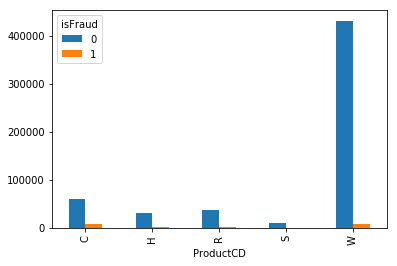

In [15]:
train.groupby('ProductCD')['isFraud'].value_counts().unstack().plot(kind='bar')
# As Expected, the proportion of Fraudulent Transactions are higher in Product Code of W and C and are least or negligible with
# Other Product Codes.

In [16]:
test['ProductCD'].value_counts(dropna=False)

W    360987
C     69266
R     35647
H     29373
S     11418
Name: ProductCD, dtype: int64

#### Card1-Card6 Variables.

In [17]:
card = [c for c in train.columns if c.startswith("card")]
card_columns = train[card]
card_columns.head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [18]:
for col in card_columns:
    print ("Number of Unique Values in {} column are".format(col),card_columns[col].nunique())

Number of Unique Values in card1 column are 13553
Number of Unique Values in card2 column are 500
Number of Unique Values in card3 column are 114
Number of Unique Values in card4 column are 4
Number of Unique Values in card5 column are 119
Number of Unique Values in card6 column are 4


As we can see above, card1,card2,card3 and card5 have a very high cardinality, specially column card1.

In [19]:
for col in card_columns:
    print ("Number of Unique Values in {} column in test dataset are".format(col),test[col].nunique())

Number of Unique Values in card1 column in test dataset are 13244
Number of Unique Values in card2 column in test dataset are 497
Number of Unique Values in card3 column in test dataset are 115
Number of Unique Values in card4 column in test dataset are 4
Number of Unique Values in card5 column in test dataset are 102
Number of Unique Values in card6 column in test dataset are 3


In [20]:
for col in card_columns:
    print ("Number of Missing Values in {} column in the training set are".format(col),card_columns[col].isna().sum())

Number of Missing Values in card1 column in the training set are 0
Number of Missing Values in card2 column in the training set are 8933
Number of Missing Values in card3 column in the training set are 1565
Number of Missing Values in card4 column in the training set are 1577
Number of Missing Values in card5 column in the training set are 4259
Number of Missing Values in card6 column in the training set are 1571


In [21]:
for col in card_columns:
    print ("Number of Missing Values in {} column in the test set are".format(col),test[col].isna().sum())

Number of Missing Values in card1 column in the test set are 0
Number of Missing Values in card2 column in the test set are 8654
Number of Missing Values in card3 column in the test set are 3002
Number of Missing Values in card4 column in the test set are 3086
Number of Missing Values in card5 column in the test set are 4547
Number of Missing Values in card6 column in the test set are 3007


In [22]:
train['card1'] = train['card1'].astype('category')
train['card1'] = train['card1'].cat.codes

train['card2'].fillna(train['card2'].value_counts(dropna=False).index[0],inplace=True)
train['card2'] = train['card2'].astype('category')
train['card2'] = train['card2'].cat.codes

train['card3'].fillna(train['card3'].value_counts(dropna=False).index[0],inplace=True)
train['card3'] = train['card3'].astype('category')
train['card3'] = train['card3'].cat.codes

train['card4'].fillna("Missing",inplace=True)
train['card4'] = train['card4'].astype('category')
train['card4'] = train['card4'].cat.codes

train['card5'].fillna(train['card5'].value_counts(dropna=False).index[0],inplace=True)
train['card5'] = train['card5'].astype('category')
train['card5'] = train['card5'].cat.codes

train['card6'].fillna("Missing",inplace=True)
train['card6'] = train['card6'].astype('category')
train['card6'] = train['card6'].cat.codes

In [23]:
test['card1'] = test['card1'].astype('category')
test['card1'] = test['card1'].cat.codes

test['card2'].fillna(test['card2'].value_counts(dropna=False).index[0],inplace=True)
test['card2'] = test['card2'].astype('category')
test['card2'] = test['card2'].cat.codes

test['card3'].fillna(test['card3'].value_counts(dropna=False).index[0],inplace=True)
test['card3'] = test['card3'].astype('category')
test['card3'] = test['card3'].cat.codes

test['card4'].fillna("Missing",inplace=True)
test['card4'] = test['card4'].astype('category')
test['card4'] = test['card4'].cat.codes

test['card5'].fillna(test['card5'].value_counts(dropna=False).index[0],inplace=True)
test['card5'] = test['card5'].astype('category')
test['card5'] = test['card5'].cat.codes

test['card6'].fillna("Missing",inplace=True)
test['card6'] = test['card6'].astype('category')
test['card6'] = test['card6'].cat.codes

In [24]:
train.groupby('card4')['isFraud'].value_counts().unstack()

isFraud,0,1
card4,,
0,1536,41
1,8089,239
2,6137,514
3,182721,6496
4,371394,13373


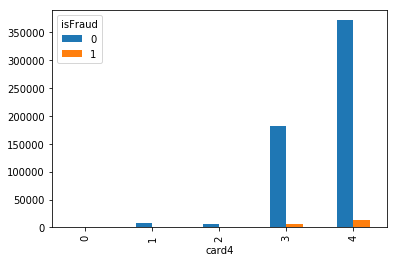

In [25]:
train.groupby('card4')['isFraud'].value_counts().unstack().plot(kind='bar')

In [26]:
train.groupby('card6')['isFraud'].value_counts().unstack()

isFraud,0,1
card6,,
0,1532.0,39.0
1,15.0,NaN
2,139036.0,9950.0
3,429264.0,10674.0
4,30.0,NaN


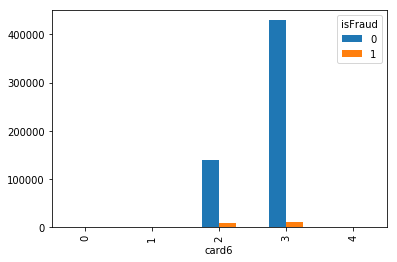

In [27]:
train.groupby('card6')['isFraud'].value_counts().unstack().plot(kind='bar')

#### Addr1 and Addr2 Variables

In [28]:
train[train['addr1'].isna()][['addr1','addr2']].head()
# Rows with addr1 as missing have addr2 as missing too.

,addr1,addr2
10,NaN,NaN
11,NaN,NaN
40,NaN,NaN
48,NaN,NaN
49,NaN,NaN


In [29]:
test[test['addr1'].isna()][['addr1','addr2']].head()
# Rows with addr1 as missing have addr2 as missing too.

,addr1,addr2
37,NaN,NaN
48,NaN,NaN
52,NaN,NaN
53,NaN,NaN
120,NaN,NaN


In [30]:
print ("Percentage Of Missing Values in {} Column is:".format("addr1"),train['addr1'].isna().sum()/len(train))
print ("Number Of Unique Values in {} Column are:".format("addr1"),train['addr1'].nunique())
print ("Percentage Of Missing Values in {} Column is:".format("addr2"),train['addr2'].isna().sum()/len(train))
print ("Number Of Unique Values in {} Column are:".format("addr2"),train['addr2'].nunique())

Percentage Of Missing Values in addr1 Column is: 0.1112642666034477
Number Of Unique Values in addr1 Column are: 332
Percentage Of Missing Values in addr2 Column is: 0.1112642666034477
Number Of Unique Values in addr2 Column are: 74


In [31]:
print ("Percentage Of Missing Values in {} Column is:".format("addr1"),test['addr1'].isna().sum()/len(test))
print ("Number Of Unique Values in {} Column are:".format("addr1"),test['addr1'].nunique())
print ("Percentage Of Missing Values in {} Column is:".format("addr2"),test['addr2'].isna().sum()/len(test))
print ("Number Of Unique Values in {} Column are:".format("addr2"),test['addr2'].nunique())

Percentage Of Missing Values in addr1 Column is: 0.1294852286699389
Number Of Unique Values in addr1 Column are: 292
Percentage Of Missing Values in addr2 Column is: 0.1294852286699389
Number Of Unique Values in addr2 Column are: 72


In [32]:
train['addr1'].value_counts(dropna=False).head()
# Missing values constitute the Highest number, so creating a new column addr1_Missing indicating Missing values in the column.

NaN      65706
299.0    46335
325.0    42751
204.0    42020
264.0    39870
Name: addr1, dtype: int64

In [33]:
train['addr2'].value_counts(dropna=False).head()

87.0    520481
NaN      65706
60.0      3084
96.0       638
32.0        91
Name: addr2, dtype: int64

In [34]:
test['addr1'].value_counts(dropna=False).head()

NaN      65609
299.0    38710
204.0    35049
325.0    34151
264.0    32710
Name: addr1, dtype: int64

In [35]:
test['addr2'].value_counts(dropna=False).head()

87.0    435934
NaN      65609
60.0      4041
96.0       608
32.0        61
Name: addr2, dtype: int64

In [36]:
train['addr1_Missing'] = train['addr1'].isna()
train['addr1'].fillna("Missing",inplace=True)
train['addr1'] = train['addr1'].astype('category').cat.codes

train['addr2_Missing'] = train['addr2'].isna()
train['addr2'].fillna("Missing",inplace=True)
train['addr2'] = train['addr2'].astype('category').cat.codes

In [37]:
test['addr1_Missing'] = test['addr1'].isna()
test['addr1'].fillna("Missing",inplace=True)
test['addr1'] = test['addr1'].astype('category').cat.codes

test['addr2_Missing'] = test['addr2'].isna()
test['addr2'].fillna("Missing",inplace=True)
test['addr2'] = test['addr2'].astype('category').cat.codes

#### P_emaildomain and R_emaildomain Variables

In [38]:
train[['P_emaildomain','R_emaildomain']].head()

,P_emaildomain,R_emaildomain
0,NaN,NaN
1,gmail.com,NaN
2,outlook.com,NaN
3,yahoo.com,NaN
4,gmail.com,NaN


In [39]:
test[['P_emaildomain','R_emaildomain']].head()

,P_emaildomain,R_emaildomain
0,gmail.com,NaN
1,aol.com,NaN
2,hotmail.com,NaN
3,gmail.com,NaN
4,gmail.com,NaN


In [40]:
print ("Percentage Of Missing Values in {} Column is:".format("P_emaildomain"),train['P_emaildomain'].isna().sum()/len(train))
print ("Number Of Unique Values in {} Column are:".format("P_emaildomain"),train['P_emaildomain'].nunique())
print ("Percentage Of Missing Values in {} Column is:".format("R_emaildomain"),train['R_emaildomain'].isna().sum()/len(train))
print ("Number Of Unique Values in {} Column are:".format("R_emaildomain"),train['R_emaildomain'].nunique())

Percentage Of Missing Values in P_emaildomain Column is: 0.1599485216920107
Number Of Unique Values in P_emaildomain Column are: 59
Percentage Of Missing Values in R_emaildomain Column is: 0.7675161716395164
Number Of Unique Values in R_emaildomain Column are: 60


In [41]:
print ("Percentage Of Missing Values in {} Column is:".format("P_emaildomain"),test['P_emaildomain'].isna().sum()/len(test))
print ("Number Of Unique Values in {} Column are:".format("P_emaildomain"),test['P_emaildomain'].nunique())
print ("Percentage Of Missing Values in {} Column is:".format("R_emaildomain"),test['R_emaildomain'].isna().sum()/len(test))
print ("Number Of Unique Values in {} Column are:".format("R_emaildomain"),test['R_emaildomain'].nunique())

Percentage Of Missing Values in P_emaildomain Column is: 0.13655659958436206
Number Of Unique Values in P_emaildomain Column are: 60
Percentage Of Missing Values in R_emaildomain Column is: 0.7318484046489873
Number Of Unique Values in R_emaildomain Column are: 60


In [42]:
# Since the R_emaildomain in both Training and Testing datasets has higher percentage of Missing values, it makes sense to delete
train.drop("R_emaildomain",axis=1,inplace=True)
test.drop("R_emaildomain",axis=1,inplace=True)

In [43]:
train['P_emaildomain'].value_counts(dropna=False).head()

gmail.com        228355
yahoo.com        100934
NaN               94456
hotmail.com       45250
anonymous.com     36998
Name: P_emaildomain, dtype: int64

In [44]:
test['P_emaildomain'].value_counts(dropna=False).head()

gmail.com        207448
yahoo.com         81850
NaN               69192
hotmail.com       40399
anonymous.com     34064
Name: P_emaildomain, dtype: int64

In [45]:
# Since there are lot of missing values, it makes sense to create an is_missing columnn with respect to P_emaildomain variable.
train['P_email_Missing'] = train['P_emaildomain'].isna()
train['P_emaildomain'].fillna("Missing",inplace=True)
train['P_emaildomain'] = train['P_emaildomain'].astype('category').cat.codes

In [46]:
test['P_email_Missing'] = test['P_emaildomain'].isna()
test['P_emaildomain'].fillna("Missing",inplace=True)
test['P_emaildomain'] = test['P_emaildomain'].astype('category').cat.codes

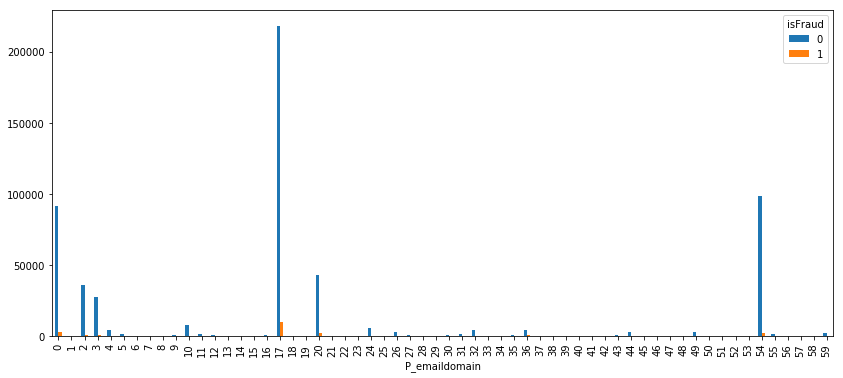

In [47]:
train.groupby('P_emaildomain')['isFraud'].value_counts().unstack().plot(kind='bar',figsize=(14,6))

#### M1 to M9 Variables

In [48]:
m_cols = [col for col in train.columns if col.startswith("M")]
train[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
test[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,F,NaN,NaN,F,T,T,T
1,T,F,F,M0,NaN,F,NaN,NaN,NaN
2,T,T,F,M0,F,F,F,F,F
3,T,T,T,NaN,NaN,T,NaN,NaN,NaN
4,T,T,T,NaN,NaN,F,F,T,T


In [50]:
for col in m_cols:
    print ("Number of Unique Values in {} Column are:".format(col),train[col].nunique())
    print ("Percentage of Missing Values in {} Column is:".format(col),train[col].isna().sum()/len(train))
    print ("--------------------------------------------------------------------------")

Number of Unique Values in M1 Column are: 2
Percentage of Missing Values in M1 Column is: 0.4590713584177194
--------------------------------------------------------------------------
Number of Unique Values in M2 Column are: 2
Percentage of Missing Values in M2 Column is: 0.4590713584177194
--------------------------------------------------------------------------
Number of Unique Values in M3 Column are: 2
Percentage of Missing Values in M3 Column is: 0.4590713584177194
--------------------------------------------------------------------------
Number of Unique Values in M4 Column are: 3
Percentage of Missing Values in M4 Column is: 0.47658753005723575
--------------------------------------------------------------------------
Number of Unique Values in M5 Column are: 2
Percentage of Missing Values in M5 Column is: 0.5934940901547736
--------------------------------------------------------------------------
Number of Unique Values in M6 Column are: 2
Percentage of Missing Values in M6 

1. Most of the M1-M9 columns have either 2 or 3 Unique Values.
2. All of these columns have a lot of Missing Values.
3. Except M4, rest of the columns have either True or False Values.

In [51]:
for col in m_cols:
    print ("Number of Unique Values in {} Column are:".format(col),test[col].nunique())
    print ("Percentage of Missing Values in {} Column is:".format(col),test[col].isna().sum()/len(test))
    print ("--------------------------------------------------------------------------")

Number of Unique Values in M1 Column are: 2
Percentage of Missing Values in M1 Column is: 0.348612862671727
--------------------------------------------------------------------------
Number of Unique Values in M2 Column are: 2
Percentage of Missing Values in M2 Column is: 0.348612862671727
--------------------------------------------------------------------------
Number of Unique Values in M3 Column are: 2
Percentage of Missing Values in M3 Column is: 0.348612862671727
--------------------------------------------------------------------------
Number of Unique Values in M4 Column are: 3
Percentage of Missing Values in M4 Column is: 0.4692110181550491
--------------------------------------------------------------------------
Number of Unique Values in M5 Column are: 2
Percentage of Missing Values in M5 Column is: 0.6110864412432824
--------------------------------------------------------------------------
Number of Unique Values in M6 Column are: 2
Percentage of Missing Values in M6 Colu

In [52]:
train[train['M1'].isna()][['M1','M2','M3']]
# The number of Missing values across columns M1,M2 and M3 are the same.

,M1,M2,M3
1,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
...,...,...,...
590526,NaN,NaN,NaN
590529,NaN,NaN,NaN
590530,NaN,NaN,NaN
590531,NaN,NaN,NaN


In [53]:
train[train['M7'].isna()][['M7','M8','M9']]
# The number of Missing values across columns M7,M8 and M9 are the same.

,M7,M8,M9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
...,...,...,...
590530,NaN,NaN,NaN
590531,NaN,NaN,NaN
590534,NaN,NaN,NaN
590537,NaN,NaN,NaN


In [54]:
train['M4'].value_counts(dropna=False)

NaN    281444
M0     196405
M2      59865
M1      52826
Name: M4, dtype: int64

In [55]:
train['M1'].fillna("Missing",inplace=True)
train['M1'] = train['M1'].astype('category').cat.codes

train['M2'].fillna("Missing",inplace=True)
train['M2'] = train['M2'].astype('category').cat.codes

train['M3'].fillna("Missing",inplace=True)
train['M3'] = train['M3'].astype('category').cat.codes

train['M4'].fillna("Missing",inplace=True)
train['M4'] = train['M4'].astype('category').cat.codes

train['M5'].fillna("Missing",inplace=True)
train['M5'] = train['M5'].astype('category').cat.codes

train['M6'].fillna("Missing",inplace=True)
train['M6'] = train['M6'].astype('category').cat.codes

train['M7'].fillna("Missing",inplace=True)
train['M7'] = train['M7'].astype('category').cat.codes

train['M8'].fillna("Missing",inplace=True)
train['M8'] = train['M8'].astype('category').cat.codes

train['M9'].fillna("Missing",inplace=True)
train['M9'] = train['M9'].astype('category').cat.codes

In [56]:
test['M1'].fillna("Missing",inplace=True)
test['M1'] = test['M1'].astype('category').cat.codes

test['M2'].fillna("Missing",inplace=True)
test['M2'] = test['M2'].astype('category').cat.codes

test['M3'].fillna("Missing",inplace=True)
test['M3'] = test['M3'].astype('category').cat.codes

test['M4'].fillna("Missing",inplace=True)
test['M4'] = test['M4'].astype('category').cat.codes

test['M5'].fillna("Missing",inplace=True)
test['M5'] = test['M5'].astype('category').cat.codes

test['M6'].fillna("Missing",inplace=True)
test['M6'] = test['M6'].astype('category').cat.codes

test['M7'].fillna("Missing",inplace=True)
test['M7'] = test['M7'].astype('category').cat.codes

test['M8'].fillna("Missing",inplace=True)
test['M8'] = test['M8'].astype('category').cat.codes

test['M9'].fillna("Missing",inplace=True)
test['M9'] = test['M9'].astype('category').cat.codes

#### Device Type Variable

In [57]:
train['DeviceType'].value_counts(dropna=False)

NaN        449730
desktop     85165
mobile      55645
Name: DeviceType, dtype: int64

In [58]:
test['DeviceType'].value_counts(dropna=False)

NaN        369760
desktop     74403
mobile      62528
Name: DeviceType, dtype: int64

In [59]:
train['DeviceType_Missing'] = train['DeviceType'].isna()
train['DeviceType'].fillna("Missing",inplace=True)

In [60]:
test['DeviceType_Missing'] = test['DeviceType'].isna()
test['DeviceType'].fillna("Missing",inplace=True)

In [61]:
train.groupby('DeviceType')['isFraud'].mean()
# Although the Number of Mobile devices are less in number, the percentage of Fraudulent Transactions is highest.

DeviceType
Missing    0.021017
desktop    0.065215
mobile     0.101662
Name: isFraud, dtype: float64

Text(0.5, 1.0, 'Fraudulent Transactions Grouped By Device Type')

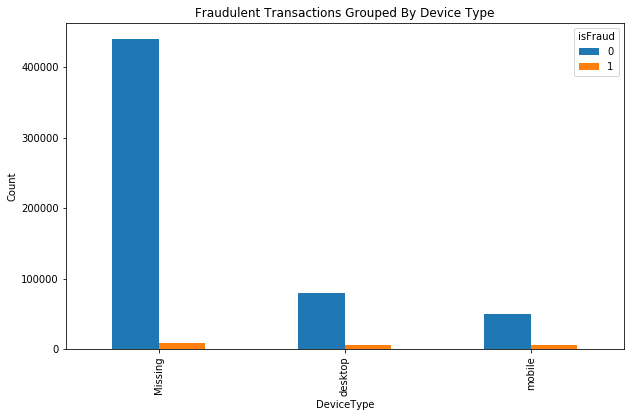

In [62]:
train.groupby('DeviceType')['isFraud'].value_counts().unstack().plot(kind='bar',figsize=(10,6))
plt.ylabel("Count")
plt.title("Fraudulent Transactions Grouped By Device Type")

#### Device Info Variable

In [63]:
print ("Number Of Unique Values in {} Variable are:".format("DeviceInfo"),train['DeviceInfo'].nunique())

Number Of Unique Values in DeviceInfo Variable are: 1786


In [64]:
train['DeviceInfo'].value_counts(dropna=False).head()

NaN            471874
Windows         47722
iOS Device      19782
MacOS           12573
Trident/7.0      7440
Name: DeviceInfo, dtype: int64

In [65]:
print ("Number Of Unique Values in {} Variable are:".format("DeviceInfo"),test['DeviceInfo'].nunique())

Number Of Unique Values in DeviceInfo Variable are: 2226


In [66]:
train['DeviceInfo_Missing'] = train['DeviceInfo'].isna()
train['DeviceInfo'].fillna("Missing",inplace=True)
train['DeviceInfo'] = train['DeviceInfo'].astype('category').cat.codes

In [67]:
test['DeviceInfo_Missing'] = test['DeviceInfo'].isna()
test['DeviceInfo'].fillna("Missing",inplace=True)
test['DeviceInfo'] = test['DeviceInfo'].astype('category').cat.codes

#### id_01 to id_38 Variables.

In [68]:
cols = [col for col in train.columns if col.startswith("id")]
id_cols = train[cols]
id_cols.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [69]:
test[cols].head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
for col in cols:
    print ("Number of Unique Values in {} Column are:".format(col),train[col].nunique())
    print ("Percentage of Missing Values in {} Column is:".format(col),train[col].isna().sum()/len(train))
    print ("--------------------------------------------------------------------------")

Number of Unique Values in id_01 Column are: 77
Percentage of Missing Values in id_01 Column is: 0.7557608290716971
--------------------------------------------------------------------------
Number of Unique Values in id_02 Column are: 115655
Percentage of Missing Values in id_02 Column is: 0.7614522301622244
--------------------------------------------------------------------------
Number of Unique Values in id_03 Column are: 24
Percentage of Missing Values in id_03 Column is: 0.8876892335828225
--------------------------------------------------------------------------
Number of Unique Values in id_04 Column are: 15
Percentage of Missing Values in id_04 Column is: 0.8876892335828225
--------------------------------------------------------------------------
Number of Unique Values in id_05 Column are: 93
Percentage of Missing Values in id_05 Column is: 0.7682375452975243
--------------------------------------------------------------------------
Number of Unique Values in id_06 Column a

1. The Minimum percentage of values missing in id_XX columns is around 75%. This can be attributed to the fact that the train_identity data had Details with respect to only a fraction of TransactionID's in the transaction dataset. 
2. Some of these variables have high cardinality, like id_02 for example. Some of them are Binary in nature.

In [71]:
for col in cols:
    print ("Number of Unique Values in {} Column are:".format(col),test[col].nunique())
    print ("Percentage of Missing Values in {} Column is:".format(col),test[col].isna().sum()/len(test))
    print ("--------------------------------------------------------------------------")

Number of Unique Values in id_01 Column are: 80
Percentage of Missing Values in id_01 Column is: 0.7199338452824305
--------------------------------------------------------------------------
Number of Unique Values in id_02 Column are: 114868
Percentage of Missing Values in id_02 Column is: 0.7296656147435024
--------------------------------------------------------------------------
Number of Unique Values in id_03 Column are: 22
Percentage of Missing Values in id_03 Column is: 0.8687938013503299
--------------------------------------------------------------------------
Number of Unique Values in id_04 Column are: 15
Percentage of Missing Values in id_04 Column is: 0.8687938013503299
--------------------------------------------------------------------------
Number of Unique Values in id_05 Column are: 90
Percentage of Missing Values in id_05 Column is: 0.7340588248064402
--------------------------------------------------------------------------
Number of Unique Values in id_06 Column a

In [72]:
common_id = []
for col in id_cols:
    if (train[col].isna().sum()/len(train) > 0.75) & (test[col].isna().sum()/len(test) > 0.75):
        common_id.append(col)
print (common_id)

['id_03', 'id_04', 'id_09', 'id_10', 'id_14', 'id_16', 'id_18', 'id_30', 'id_32', 'id_33', 'id_34']


In [73]:
train.drop(common_id,axis=1,inplace=True)
test.drop(common_id,axis=1,inplace=True)

In [74]:
cols = [col for col in train.columns if col.startswith("id")]
id_cols = train[cols]
id_cols.head()

,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,70787.0,NaN,NaN,100.0,NotFound,NaN,New,166.0,542.0,144.0,New,NotFound,samsung browser 6.2,T,F,T,T


In [75]:
for col in cols:
    train[col+"_Missing"] = train[col].isna()
    
for col in cols:
    test[col+"_Missing"] = test[col].isna()

In [76]:
for col in cols:
    train[col].fillna("Missing",inplace=True)

for col in cols:
    test[col].fillna("Missing",inplace=True)

In [77]:
for col in cols:
    train[col] = train[col].astype('category').cat.codes

for col in cols:
    test[col] = test[col].astype('category').cat.codes

#### Exploring the Dependent isFraud Variable

In [78]:
train['isFraud'].value_counts(dropna=False)/len(train)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

This is a classic case of Class Imbalance as it occurs in real life. Fraudulent transactions form just 3.5% of the total number of transactions.

Text(0.5, 1.0, 'Distribution of isFraud(Dependent) Variable')

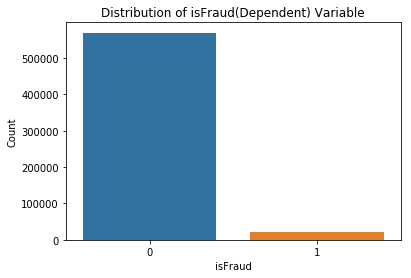

In [79]:
sns.countplot(train['isFraud'])
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.title("Distribution of isFraud(Dependent) Variable")

#### dist1 and dist2 variables.

In [80]:
train['dist1'].describe()

count    238269.000000
mean        118.502180
std         371.872026
min           0.000000
25%           3.000000
50%           8.000000
75%          24.000000
max       10286.000000
Name: dist1, dtype: float64

1. There are a lot of Missing values in this variables.
2. Maximum distance is 10286 Units, considering the distribution of this variable, this definitely has to be an outlier.
3. The Minimum distance of 0 Units also doesn't make sense.

In [81]:
test['dist1'].describe()

count    215474.000000
mean         87.065270
std         314.131694
min           0.000000
25%           3.000000
50%           8.000000
75%          20.000000
max        8081.000000
Name: dist1, dtype: float64

In [82]:
train['dist1'].fillna(train['dist1'].median(),inplace=True)
test['dist1'].fillna(test['dist1'].median(),inplace=True)

#### Numerical Variables

##### TransactionAmt Variable

In [83]:
train[train['TransactionAmt'].isna()]
# No Missing Values Here

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,addr1_Missing,addr2_Missing,P_email_Missing,DeviceType_Missing,DeviceInfo_Missing,id_01_Missing,id_02_Missing,id_05_Missing,id_06_Missing,id_11_Missing,id_12_Missing,id_13_Missing,id_15_Missing,id_17_Missing,id_19_Missing,id_20_Missing,id_28_Missing,id_29_Missing,id_31_Missing,id_35_Missing,id_36_Missing,id_37_Missing,id_38_Missing


In [84]:
test[test['TransactionAmt'].isna()]

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,addr1_Missing,addr2_Missing,P_email_Missing,DeviceType_Missing,DeviceInfo_Missing,id_01_Missing,id_02_Missing,id_05_Missing,id_06_Missing,id_11_Missing,id_12_Missing,id_13_Missing,id_15_Missing,id_17_Missing,id_19_Missing,id_20_Missing,id_28_Missing,id_29_Missing,id_31_Missing,id_35_Missing,id_36_Missing,id_37_Missing,id_38_Missing


In [85]:
train['TransactionAmt'].describe()

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

In [86]:
test['TransactionAmt'].describe()

count    506691.000000
mean        134.725568
std         245.779822
min           0.018000
25%          40.000000
50%          67.950000
75%         125.000000
max       10270.000000
Name: TransactionAmt, dtype: float64

In [87]:
train.groupby('isFraud')['TransactionAmt'].agg({'min','max','mean','median'})

,min,mean,median,max
isFraud,,,,
0,0.251,134.511665,68.5,31937.391
1,0.292,149.244779,75.0,5191.000


1. There is some difference between the Mean Transaction Amounts of Fraudulent and Non Fraudulent Cases.
2. The Max value in Non Fraudulent case may be an anomaly.
3. There is difference in the Median values as well.

Text(0.5, 1.0, 'Distribution Plot of Transaction Amount variable')

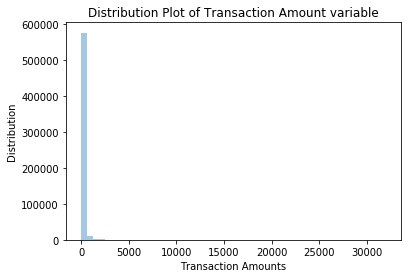

In [88]:
sns.distplot(train['TransactionAmt'],kde=False)
plt.xlabel("Transaction Amounts")
plt.ylabel("Distribution")
plt.title("Distribution Plot of Transaction Amount variable")

Text(0.5, 1.0, "Distribution Plot of 'Log of Transaction Amount' variable")

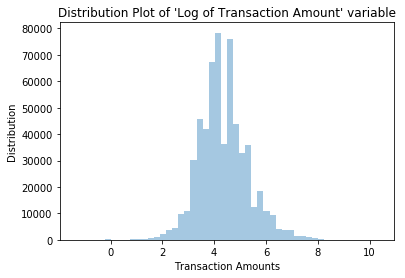

In [89]:
sns.distplot(np.log(train['TransactionAmt']),kde=False)
plt.xlabel("Transaction Amounts")
plt.ylabel("Distribution")
plt.title("Distribution Plot of 'Log of Transaction Amount' variable")
# More or less this looks like a normal distribution.

Text(0.5, 1.0, "Distribution Plot of 'Log of Transaction Amount' variable")

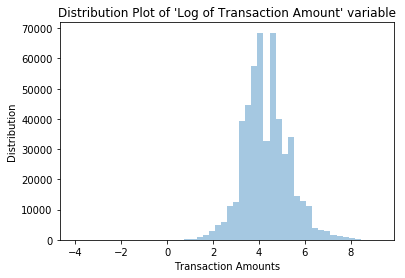

In [90]:
sns.distplot(np.log(test['TransactionAmt']),kde=False)
plt.xlabel("Transaction Amounts")
plt.ylabel("Distribution")
plt.title("Distribution Plot of 'Log of Transaction Amount' variable")
# More or less this looks like a normal distribution.

#### C1 to C14 Variables.

In [91]:
cols = [col for col in train.columns if col.startswith("C")]
c_cols = train[cols]
c_cols.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [92]:
test[cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0
1,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0
2,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0
3,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0
4,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0


In [93]:
for col in cols:
    print ("Number of Unique Values in {} Column are:".format(col),train[col].nunique())
    print ("Percentage of Missing Values in {} Column is:".format(col),train[col].isna().sum()/len(train))
    print ("--------------------------------------------------------------------------")

Number of Unique Values in C1 Column are: 1657
Percentage of Missing Values in C1 Column is: 0.0
--------------------------------------------------------------------------
Number of Unique Values in C2 Column are: 1216
Percentage of Missing Values in C2 Column is: 0.0
--------------------------------------------------------------------------
Number of Unique Values in C3 Column are: 27
Percentage of Missing Values in C3 Column is: 0.0
--------------------------------------------------------------------------
Number of Unique Values in C4 Column are: 1260
Percentage of Missing Values in C4 Column is: 0.0
--------------------------------------------------------------------------
Number of Unique Values in C5 Column are: 319
Percentage of Missing Values in C5 Column is: 0.0
--------------------------------------------------------------------------
Number of Unique Values in C6 Column are: 1328
Percentage of Missing Values in C6 Column is: 0.0
----------------------------------------------

1. None of the Columns C1-C14 have missing values. 
2. Some of these have high cardinality.

In [94]:
for col in cols:
    print ("Number of Unique Values in {} Column are:".format(col),test[col].nunique())
    print ("Percentage of Missing Values in {} Column is:".format(col),test[col].isna().sum()/len(test))
    print ("--------------------------------------------------------------------------")

Number of Unique Values in C1 Column are: 1174
Percentage of Missing Values in C1 Column is: 5.920768278891869e-06
--------------------------------------------------------------------------
Number of Unique Values in C2 Column are: 1123
Percentage of Missing Values in C2 Column is: 5.920768278891869e-06
--------------------------------------------------------------------------
Number of Unique Values in C3 Column are: 31
Percentage of Missing Values in C3 Column is: 5.920768278891869e-06
--------------------------------------------------------------------------
Number of Unique Values in C4 Column are: 728
Percentage of Missing Values in C4 Column is: 5.920768278891869e-06
--------------------------------------------------------------------------
Number of Unique Values in C5 Column are: 353
Percentage of Missing Values in C5 Column is: 5.920768278891869e-06
--------------------------------------------------------------------------
Number of Unique Values in C6 Column are: 834
Percenta

In [95]:
for col in cols:
    test[col].fillna(test[col].value_counts(dropna=False).index[0],inplace=True)

#### D1 to D15 Variables.

In [96]:
cols = ["D1","D2","D3","D4","D5","D6","D7","D8","D9","D10","D11","D12","D13","D14","D15"]
d_cols = train[cols]
d_cols.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
test[cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0
1,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0
2,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,136.0,NaN,NaN,NaN,97.0
3,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,242.0,NaN,NaN,NaN,242.0
4,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,22.0


In [98]:
for col in cols:
    print ("Number of Unique Values in {} Column are:".format(col),train[col].nunique())
    print ("Percentage of Missing Values in {} Column is:".format(col),train[col].isna().sum()/len(train))
    print ("--------------------------------------------------------------------------")

Number of Unique Values in D1 Column are: 641
Percentage of Missing Values in D1 Column is: 0.0021488806854743116
--------------------------------------------------------------------------
Number of Unique Values in D2 Column are: 641
Percentage of Missing Values in D2 Column is: 0.4754919226470688
--------------------------------------------------------------------------
Number of Unique Values in D3 Column are: 649
Percentage of Missing Values in D3 Column is: 0.44514850814508755
--------------------------------------------------------------------------
Number of Unique Values in D4 Column are: 808
Percentage of Missing Values in D4 Column is: 0.2860466691502693
--------------------------------------------------------------------------
Number of Unique Values in D5 Column are: 688
Percentage of Missing Values in D5 Column is: 0.524674027161581
--------------------------------------------------------------------------
Number of Unique Values in D6 Column are: 829
Percentage of Missing

1. Except Column D1 rest of the columns have high percentage of Missing values.
2. Except D9, rest of the columns have lot of Unique Values. This can be attributed to the fact that it is pertaining to the time of the day (in terms of Hours).

In [99]:
for col in cols:
    print ("Number of Unique Values in {} Column are:".format(col),test[col].nunique())
    print ("Percentage of Missing Values in {} Column is:".format(col),test[col].isna().sum()/len(test))
    print ("--------------------------------------------------------------------------")

Number of Unique Values in D1 Column are: 642
Percentage of Missing Values in D1 Column is: 0.011902717829998953
--------------------------------------------------------------------------
Number of Unique Values in D2 Column are: 642
Percentage of Missing Values in D2 Column is: 0.4633376160223884
--------------------------------------------------------------------------
Number of Unique Values in D3 Column are: 887
Percentage of Missing Values in D3 Column is: 0.400918903236884
--------------------------------------------------------------------------
Number of Unique Values in D4 Column are: 1056
Percentage of Missing Values in D4 Column is: 0.151672321000373
--------------------------------------------------------------------------
Number of Unique Values in D5 Column are: 961
Percentage of Missing Values in D5 Column is: 0.44282412752545436
--------------------------------------------------------------------------
Number of Unique Values in D6 Column are: 1072
Percentage of Missing

In [100]:
common_d = []
for col in cols:
    if (train[col].isna().sum()/len(train) > 0.8) & (test[col].isna().sum()/len(test) > 0.8):
        common_d.append(col)
print (common_d)    

['D7', 'D8', 'D9', 'D12']


In [101]:
train.drop(["D7","D8","D12"],axis=1,inplace=True)
test.drop(["D7","D8","D12"],axis=1,inplace=True)

In [102]:
cols = ["D1","D2","D3","D4","D5","D6","D9","D10","D11","D13","D14","D15"]

In [103]:
for col in cols:
    train[col].fillna(0.0,inplace=True)
    
for col in cols:
    test[col].fillna(0.0,inplace=True)

#### V1 - V339 Variables

In [104]:
cols = [col for col in train.columns if col[0]=="V"]
v_cols = train[cols]
v_cols.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [105]:
test[cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [106]:
for col in cols:
    if train[col].nunique() == 2:
        print ("Unique Values in {} Column in Training Set are:".format(col),train[col].unique())
        print ("Percentage of Missing Values in {} Column in Training Set is:".format(col),train[col].isna().sum()/len(train))
        print ("--------------------------------------------------------------------------")

Unique Values in V1 Column in Training Set are: [ 1. nan  0.]
Percentage of Missing Values in V1 Column in Training Set is: 0.47293494090154775
--------------------------------------------------------------------------
Unique Values in V14 Column in Training Set are: [ 1. nan  0.]
Percentage of Missing Values in V14 Column in Training Set is: 0.1288193856470349
--------------------------------------------------------------------------
Unique Values in V41 Column in Training Set are: [nan  1.  0.]
Percentage of Missing Values in V41 Column in Training Set is: 0.2861262573238053
--------------------------------------------------------------------------
Unique Values in V65 Column in Training Set are: [ 1. nan  0.]
Percentage of Missing Values in V65 Column in Training Set is: 0.13055169844549055
--------------------------------------------------------------------------
Unique Values in V88 Column in Training Set are: [ 1. nan  0.]
Percentage of Missing Values in V88 Column in Training Se

In [107]:
for col in cols:
    if test[col].nunique() == 2:
        print ("Unique Values in {} Column in Test Set are:".format(col),test[col].unique())
        print ("Percentage of Missing Values in {} Column in Test Set is:".format(col),test[col].isna().sum()/len(test))
        print ("--------------------------------------------------------------------------")

Unique Values in V1 Column in Test Set are: [ 1. nan  0.]
Percentage of Missing Values in V1 Column in Test Set is: 0.348374058351145
--------------------------------------------------------------------------
Unique Values in V14 Column in Test Set are: [ 1. nan  0.]
Percentage of Missing Values in V14 Column in Test Set is: 0.02484551728765658
--------------------------------------------------------------------------
Unique Values in V41 Column in Test Set are: [ 1. nan  0.]
Percentage of Missing Values in V41 Column in Test Set is: 0.1516782417686519
--------------------------------------------------------------------------
Unique Values in V65 Column in Test Set are: [ 1. nan  0.]
Percentage of Missing Values in V65 Column in Test Set is: 0.02545733000980874
--------------------------------------------------------------------------
Unique Values in V88 Column in Test Set are: [ 1. nan  0.]
Percentage of Missing Values in V88 Column in Test Set is: 0.023842933859097557
--------------

In [108]:
for col in ["V1","V14","V41","V65","V88","V107","V305"]:
    print ("Value Counts in {} Variable:".format(col))
    print (train[col].value_counts(dropna=False))

Value Counts in V1 Variable:
1.0    311236
NaN    279287
0.0        17
Name: V1, dtype: int64
Value Counts in V14 Variable:
1.0    514210
NaN     76073
0.0       257
Name: V14, dtype: int64
Value Counts in V41 Variable:
1.0    421263
NaN    168969
0.0       308
Name: V41, dtype: int64
Value Counts in V65 Variable:
1.0    513271
NaN     77096
0.0       173
Name: V65, dtype: int64
Value Counts in V88 Variable:
1.0    500998
NaN     89164
0.0       378
Name: V88, dtype: int64
Value Counts in V107 Variable:
1.0    589978
NaN       314
0.0       248
Name: V107, dtype: int64
Value Counts in V305 Variable:
1.0    590524
NaN        12
2.0         4
Name: V305, dtype: int64


In [109]:
for col in ["V1","V14","V41","V65","V88","V107","V305"]:
    train[col].fillna(train[col].value_counts(dropna=False).index[0],inplace=True)
for col in ["V1","V14","V41","V65","V88","V107","V305"]:
    test[col].fillna(test[col].value_counts(dropna=False).index[0],inplace=True)

In [110]:
common_v = []
for col in cols:
    if (train[col].isna().sum()/len(train) > 0.8) & (test[col].isna().sum()/len(test) > 0.8):
        common_v.append(col)
print (common_v) 

['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']


In [111]:
train.drop(common_v,axis=1,inplace=True)
test.drop(common_v,axis=1,inplace=True)

In [112]:
cols = [col for col in train.columns if col[0]=="V"]
for col in cols:
    train[col].fillna(train[col].median(),inplace=True)
for col in cols:
    test[col].fillna(test[col].median(),inplace=True)

The columns in the Overfit list are dropped from the dataset because one of the values in the column represents more than 99% of the data. This will basically tilt the importance towards that value. Hence those columns are dropped.

In [113]:
overfit = []
for col in train.columns:
    counts = train[col].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 >99:
        overfit.append(col)
print (len(overfit))
print (overfit)

37
['C3', 'V1', 'V14', 'V27', 'V28', 'V41', 'V65', 'V68', 'V88', 'V89', 'V107', 'V108', 'V110', 'V111', 'V112', 'V113', 'V114', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V191', 'V192', 'V193', 'V196', 'V240', 'V241', 'V247', 'V248', 'V249', 'V252', 'V253', 'V254', 'V269', 'V305']


In [114]:
train.drop(overfit,axis=1,inplace=True)
test.drop(overfit,axis=1,inplace=True)

In [115]:
train.shape, test.shape

((590540, 347), (506691, 346))

#### Correlation Between Variables.

In [116]:
%%time
# Let's check the correlation between the variables and eliminate the one's that have high correlation
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

CPU times: user 3min 2s, sys: 13.7 s, total: 3min 16s
Wall time: 3min 16s


,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D9,D10,D11,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V66,V67,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V109,V115,V116,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V194,V195,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V242,V243,V244,V245,V246,V250,V251,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceInfo,addr1_Missing,addr2_Missing,P_email_Missing,DeviceType_Missing,DeviceInfo_Missing,id_01_Missing,id_02_Missing,id_05_Missing,id_06_Missing,id_11_Missing,id_12_Missing,id_13_Missing,id_15_Missing,id_17_Missing,id_19_Missing,id_20_Missing,id_28_Missing,id_29_Missing,id_31_Missing,id_35_Missing,id_36_Missing,id_37_Missing,id_38_Missing
isFraud,1.000000,0.013103,0.011320,0.013633,0.003093,0.154190,0.003355,0.032746,0.094601,0.103748,0.129042,0.004910,0.012668,0.030570,0.037229,0.030382,0.030754,0.020909,0.028160,0.032139,0.031703,0.028396,0.027484,0.031905,0.011146,0.007921,0.067101,0.073426,0.040230,0.053938,0.037896,0.029052,0.109771,0.071098,0.063805,0.002279,0.051684,0.074871,0.089368,0.074165,0.058027,0.033158,0.020469,0.009776,0.046810,0.005643,0.053367,0.000540,0.012044,0.027326,0.035364,0.005760,0.001628,0.000252,0.009555,0.080982,0.079090,0.035199,0.031010,0.154755,0.151645,0.158972,0.158933,0.032710,0.040118,0.143769,0.137627,0.132921,0.109155,0.004906,0.015059,0.102738,0.098517,0.141002,0.138517,0.159394,0.156433,0.056913,0.052707,0.147773,0.165903,0.166640,0.174672,0.154633,0.162243,0.217870,0.235436,0.105273,0.136954,0.091582,0.088094,0.146241,0.182007,0.195492,0.026069,0.019441,0.041215,0.050962,0.141775,0.145747,0.126433,0.126655,0.050252,0.068696,0.128124,0.125949,0.034886,0.067629,0.102396,0.099106,0.130752,0.134678,0.145810,0.156239,0.034294,0.031174,0.139049,0.131642,0.167299,0.155256,0.157356,0.049325,0.064254,0.144835,0.145019,0.222343,0.221568,0.102635,0.098592,0.154463,0.155190,0.161454,0.004121,0.005486,0.004492,0.027294,0.013191,0.011265,0.004713,0.004848,0.005121,0.003476,0.003233,0.002095,0.060963,0.057075,0.080604,0.138157,0.076675,0.111943,0.003547,0.002632,0.001933,0.012721,0.003058,0.024954,0.004264,0.003167,0.003513,0.000279,0.000047,0.000119,0.001675,0.001201,0.069512,0.203019,0.182390,0.007138,0.008965,0.048889,0.026814,0.139139,0.000169,0.000645,0.000110,0.010916,0.043214,0.009937,0.018523,0.112757,0.104747,0.119833,0.027179,0.219590,0.225829,0.161992,0.083384,0.090404,0.091731,0.090794,0.182031,0.238290,0.246462,0.001808,0.000427,0.001564,0.000834,0.000297,0.000239,0.023948,0.002845,0.018797,0.003363,0.003164,0.003268,0.011283,0.011431,0.011704,0.043414,0.046058,0.043912,0.073027,0.105510,0.131827,0.025785,0.013374,0.021657,0.011438,0.020275,0.207138,0.109597,0.179935,0.037750,0.047918,0.041479,0.007113,0.073628,0.042879,0.045241,0.107055,0.123727,0.263476,0.157394,0.265712,0.057288,0.268090,0.015869,0.0014

In [117]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D9,D10,D11,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V66,V67,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V109,V115,V116,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V194,V195,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V242,V243,V244,V245,V246,V250,V251,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceInfo,addr1_Missing,addr2_Missing,P_email_Missing,DeviceType_Missing,DeviceInfo_Missing,id_01_Missing,id_02_Missing,id_05_Missing,id_06_Missing,id_11_Missing,id_12_Missing,id_13_Missing,id_15_Missing,id_17_Missing,id_19_Missing,id_20_Missing,id_28_Missing,id_29_Missing,id_31_Missing,id_35_Missing,id_36_Missing,id_37_Missing,id_38_Missing
isFraud,NaN,0.013103,0.01132,0.013633,0.003093,0.154190,0.003355,0.032746,0.094601,0.103748,0.129042,0.004910,0.012668,0.030570,0.037229,0.030382,0.030754,0.020909,0.028160,0.032139,0.031703,0.028396,0.027484,0.031905,0.011146,0.007921,0.067101,0.073426,0.040230,0.053938,0.037896,0.029052,0.109771,0.071098,0.063805,0.002279,0.051684,0.074871,0.089368,0.074165,0.058027,0.033158,0.020469,0.009776,0.046810,0.005643,0.053367,0.000540,0.012044,0.027326,0.035364,0.005760,0.001628,0.000252,0.009555,0.080982,0.079090,0.035199,0.031010,0.154755,0.151645,0.158972,0.158933,0.032710,0.040118,0.143769,0.137627,0.132921,0.109155,0.004906,0.015059,0.102738,0.098517,0.141002,0.138517,0.159394,0.156433,0.056913,0.052707,0.147773,0.165903,0.166640,0.174672,0.154633,0.162243,0.217870,0.235436,0.105273,0.136954,0.091582,0.088094,0.146241,0.182007,0.195492,0.026069,0.019441,0.041215,0.050962,0.141775,0.145747,0.126433,0.126655,0.050252,0.068696,0.128124,0.125949,0.034886,0.067629,0.102396,0.099106,0.130752,0.134678,0.145810,0.156239,0.034294,0.031174,0.139049,0.131642,0.167299,0.155256,0.157356,0.049325,0.064254,0.144835,0.145019,0.222343,0.221568,0.102635,0.098592,0.154463,0.155190,0.161454,0.004121,0.005486,0.004492,0.027294,0.013191,0.011265,0.004713,0.004848,0.005121,0.003476,0.003233,0.002095,0.060963,0.057075,0.080604,0.138157,0.076675,0.111943,0.003547,0.002632,0.001933,0.012721,0.003058,0.024954,0.004264,0.003167,0.003513,0.000279,0.000047,0.000119,0.001675,0.001201,0.069512,0.203019,0.182390,0.007138,0.008965,0.048889,0.026814,0.139139,0.000169,0.000645,0.000110,0.010916,0.043214,0.009937,0.018523,0.112757,0.104747,0.119833,0.027179,0.219590,0.225829,0.161992,0.083384,0.090404,0.091731,0.090794,0.182031,0.238290,0.246462,0.001808,0.000427,0.001564,0.000834,0.000297,0.000239,0.023948,0.002845,0.018797,0.003363,0.003164,0.003268,0.011283,0.011431,0.011704,0.043414,0.046058,0.043912,0.073027,0.105510,0.131827,0.025785,0.013374,0.021657,0.011438,0.020275,0.207138,0.109597,0.179935,0.037750,0.047918,0.041479,0.007113,0.073628,0.042879,0.045241,0.107055,0.123727,0.263476,0.157394,0.265712,0.057288,0.268090,0.015869,0.001409,0.0

In [118]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

There are 155 columns to remove.
Following columns can be dropped ['C2', 'C4', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14', 'D2', 'V5', 'V11', 'V13', 'V16', 'V18', 'V20', 'V21', 'V22', 'V30', 'V31', 'V32', 'V33', 'V34', 'V36', 'V40', 'V43', 'V45', 'V49', 'V50', 'V51', 'V52', 'V54', 'V57', 'V58', 'V60', 'V63', 'V64', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V76', 'V79', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V94', 'V96', 'V97', 'V101', 'V102', 'V103', 'V105', 'V106', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134', 'V137', 'V167', 'V168', 'V177', 'V178', 'V179', 'V182', 'V183', 'V190', 'V197', 'V198', 'V199', 'V201', 'V202', 'V203', 'V204', 'V211', 'V212', 'V213', 'V216', 'V218', 'V219', 'V222', 'V225', 'V231', 'V232', 'V233', 'V236', 'V237', 'V239', 'V243', 'V244', 'V251', 'V256', 'V257', 'V259', 'V265', 'V266', 'V271', 'V272', 'V273', 'V274', 'V275', 'V278', 'V279', 'V280', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V301', 'V304', 'V306', 'V307

In [119]:
train.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)

In [120]:
train.shape, test.shape

((590540, 192), (506691, 191))

### Model Building

In [121]:
X = train[[col for col in train.columns if col!='isFraud']]
y = train['isFraud']

In [122]:
X = pd.get_dummies(X)
test = pd.get_dummies(test)
print (train.shape)
print (test.shape)

(590540, 192)
(506691, 197)


In [123]:
X_Train,X_Test,y_Train,y_Test = train_test_split(X,y,test_size=0.25)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(442905, 197)
(442905,)
(147635, 197)
(147635,)


In [124]:
"""clf = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=42,class_weight='balanced',n_jobs=-1,verbose=1)
params = {"max_depth":[3,4,5,6,-1],
          "learning_rate":[0.01,0.05,0.1,0.3],
          "subsample":[0.5,0.7,0.9],
          "colsample_bytree":[0.5,0.7,0.9],
          "reg_alpha":[0.5,1,2],
          "reg_lambda":[0.5,1,2],
          "num_leaves":[7,15,31,63],
          "n_estimators":list(range(50,300,50))}
random_search = RandomizedSearchCV(estimator=clf,param_distributions=params,cv=5,scoring='roc_auc')
random_search.fit(X_Train,y_Train)"""

'clf = lgb.LGBMClassifier(boosting_type=\'gbdt\',objective=\'binary\',random_state=42,class_weight=\'balanced\',n_jobs=-1,verbose=1)\nparams = {"max_depth":[3,4,5,6,-1],\n          "learning_rate":[0.01,0.05,0.1,0.3],\n          "subsample":[0.5,0.7,0.9],\n          "colsample_bytree":[0.5,0.7,0.9],\n          "reg_alpha":[0.5,1,2],\n          "reg_lambda":[0.5,1,2],\n          "num_leaves":[7,15,31,63],\n          "n_estimators":list(range(50,300,50))}\nrandom_search = RandomizedSearchCV(estimator=clf,param_distributions=params,cv=5,scoring=\'roc_auc\')\nrandom_search.fit(X_Train,y_Train)'

In [125]:
clf = xgb.XGBClassifier(random_state=42,n_jobs=-1,verbosity=1)
params = {"max_depth":[3,5,7,9],
          "n_estimators":list(range(50,301,50)),
          "learning_rate":[0.01,0.05,0.1,0.3],
          "subsample":[0.5,0.7,0.9],
          "colsample_bytree":[0.5,0.7,0.9],
          "reg_alpha":[0.5,1,2,5],
          "reg_lambda":[0.5,1,2,5]}
random_search = RandomizedSearchCV(estimator=clf,param_distributions=params,cv=5,scoring='roc_auc')
random_search.fit(X_Train,y_Train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha...
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
         

In [126]:
random_search.best_estimator_,random_search.best_params_,random_search.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.5, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=9,
               min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
               nthread=None, objective='binary:logistic', random_state=42,
               reg_alpha=2, reg_lambda=5, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.5, verbosity=1),
 {'subsample': 0.5,
  'reg_lambda': 5,
  'reg_alpha': 2,
  'n_estimators': 200,
  'max_depth': 9,
  'learning_rate': 0.1,
  'colsample_bytree': 0.5},
 0.9459134867465104)

In [127]:
"""ser = pd.Series(random_search.best_estimator_.feature_importances_,X_Train.columns).sort_values()
plt.figure(figsize=(10,10))
ser.plot(kind='bar')"""

"ser = pd.Series(random_search.best_estimator_.feature_importances_,X_Train.columns).sort_values()\nplt.figure(figsize=(10,10))\nser.plot(kind='bar')"

In [128]:
Submission['isFraud'] = random_search.best_estimator_.predict_proba(test)[:,1]
Submission.to_csv("XGB_New.csv",index=None)